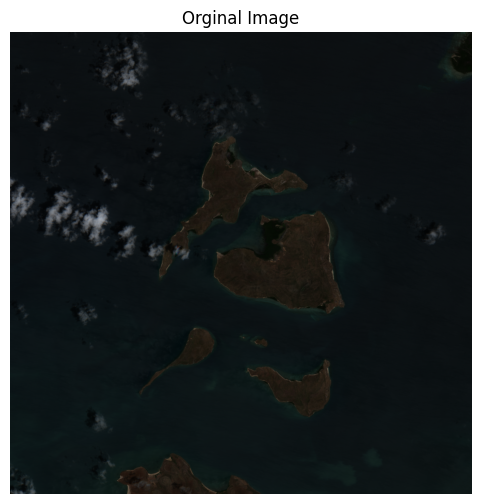

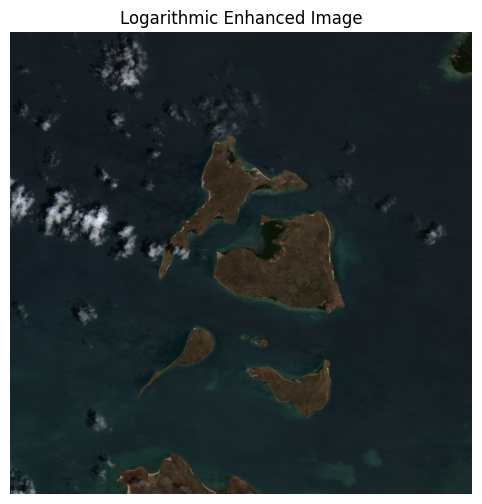

In [126]:

#febin sebastine ,sidarth rajeev

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the RGB image
with rasterio.open(r"C:\Users\febin\Downloads\rgb.tif") as src:
    img = src.read()  # (channels, height, width)

img1=np.transpose(img,(1,2,0))
plt.figure(figsize=(8, 6))
plt.title("Orginal Image")
plt.imshow(img1)
plt.axis("off")
plt.show

# Convert to float for log transform
img_float = img.astype(np.float32)

# Logarithmic enhancement
c = 255 / np.log(1 + np.max(img_float))
log_img = c * np.log(1 + img_float)
log_img = np.clip(log_img, 0, 255)  # Clip to 0-255

# Convert to shape (height, width, channels) for display
log_img_display = np.transpose(log_img, (1, 2, 0))

# Display the enhanced image
plt.figure(figsize=(8, 6))
plt.title("Logarithmic Enhanced Image")
plt.imshow(log_img_display / 255)  # Divide by 255 for float display
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0085..1.438064].


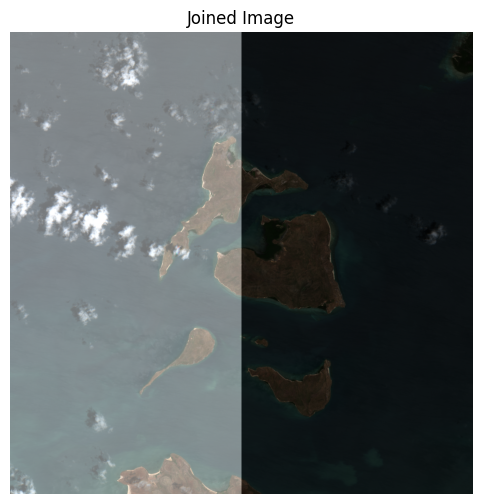

In [145]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- Load images ---
with rasterio.open(r"C:\Users\febin\Downloads\rgb_left.tif") as lft:
    left = lft.read().astype(float) # (C,H,W)

with rasterio.open(r"C:\Users\febin\Downloads\rgb_right.tif") as rgt:
    right = rgt.read().astype(float)  # (C,H,W)

# Transpose from (C,H,W) to (H,W,C) for matplotlib
left_img = np.transpose(left, (1, 2, 0))  # Now (H,W,C)
right_img = np.transpose(right, (1, 2, 0))  # Now (H,W,C)

# Concatenate along width axis (axis=1)
joined = np.concatenate([left_img, right_img], axis=1)

# --- Display ---
plt.figure(figsize=(12,6))
plt.imshow(joined)
plt.axis("off")
plt.title("Joined Image")
plt.show()


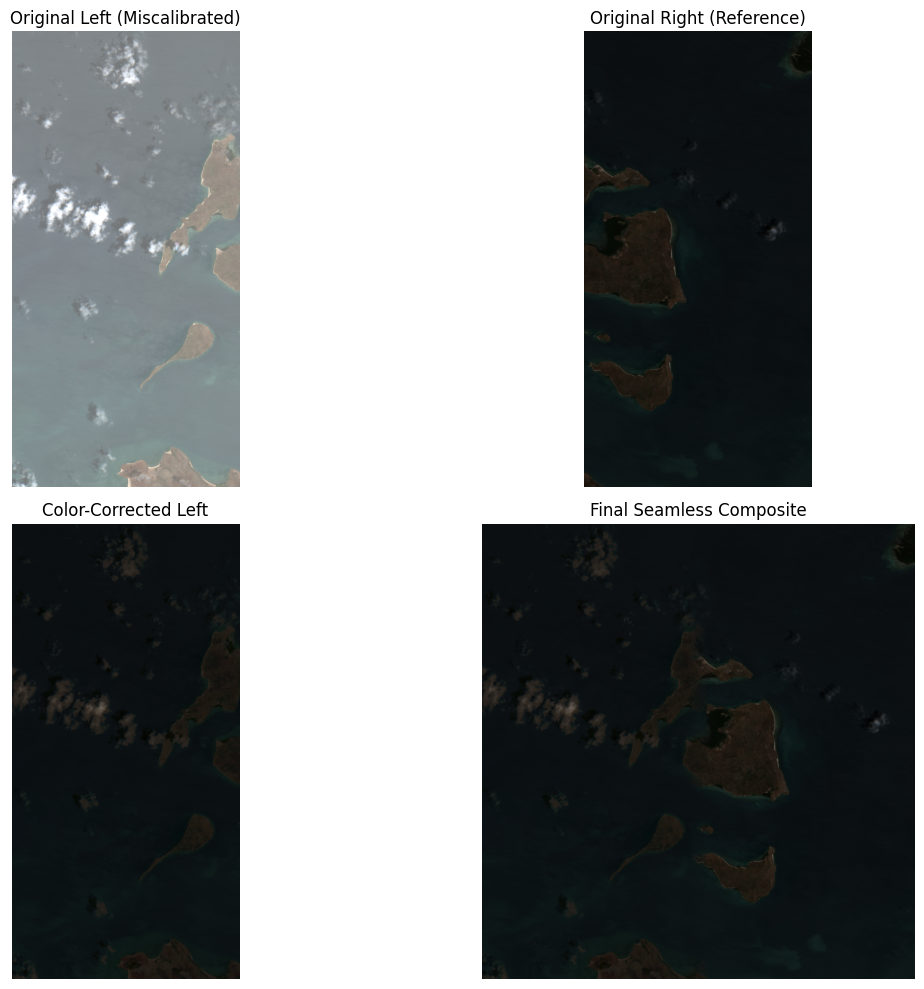

In [153]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# --- Load images (keep original float values) ---
with rasterio.open(r"C:\Users\febin\Downloads\rgb_left.tif") as lft:
    left = lft.read()  # (C, H, W)

with rasterio.open(r"C:\Users\febin\Downloads\rgb_right.tif") as rgt:
    right = rgt.read()  # (C, H, W)

# Transpose to (H, W, C) for processing
left_img = np.transpose(left, (1, 2, 0))    # Shape: (1000, 500, 3)
right_img = np.transpose(right, (1, 2, 0))  # Shape: (1000, 500, 3)

# --- Method 1: Histogram Matching for Color Correction ---
# Match left image histogram to right image (reference)
left_corrected = match_histograms(left_img, right_img, channel_axis=-1)

# --- Create seamless blend ---
H, W, C = left_corrected.shape

# Create alpha gradient for blending (feathering at the seam)
blend_width = 50  # Width of the blending zone (adjust as needed)

# Alpha mask: 1 at left edge, 0 at right edge (for left image)
alpha_left = np.ones((H, W), dtype=np.float32)
alpha_left[:, -blend_width:] = np.linspace(1, 0, blend_width)

# Alpha mask for right image: 0 at left edge, 1 at right edge
alpha_right = np.ones((H, W), dtype=np.float32)
alpha_right[:, :blend_width] = np.linspace(0, 1, blend_width)

# Expand alpha to 3 channels
alpha_left_3ch = np.stack([alpha_left]*3, axis=-1)
alpha_right_3ch = np.stack([alpha_right]*3, axis=-1)

# --- Create the composite image ---
# Final width = left_width + right_width - overlap
overlap = blend_width
final_width = W + W - overlap
composite = np.zeros((H, final_width, C), dtype=np.float32)

# Place corrected left image
composite[:, :W, :] = left_corrected * alpha_left_3ch

# Blend right image (starting with overlap)
right_start = W - overlap
composite[:, right_start:right_start+W, :] += right_img * alpha_right_3ch

# --- Display results ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original left (scaled for display)
axes[0, 0].imshow(np.clip(left_img * 255, 0, 255).astype(np.uint8))
axes[0, 0].set_title("Original Left (Miscalibrated)")
axes[0, 0].axis("off")

# Original right (reference)
axes[0, 1].imshow(np.clip(right_img * 255, 0, 255).astype(np.uint8))
axes[0, 1].set_title("Original Right (Reference)")
axes[0, 1].axis("off")

# Corrected left
axes[1, 0].imshow(np.clip(left_corrected * 255, 0, 255).astype(np.uint8))
axes[1, 0].set_title("Color-Corrected Left")
axes[1, 0].axis("off")

# Final blended composite
axes[1, 1].imshow(np.clip(composite * 255, 0, 255).astype(np.uint8))
axes[1, 1].set_title("Final Seamless Composite")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# --- Save final result ---
# plt.imsave("seamless_composite.png", np.clip(composite * 255, 0, 255).astype(np.uint8))
